# Suboptimal Compression
Inspect how much compression we get for each sequence when using suboptimal alignments.

In [5]:
import glob
import re

import numpy as np
import pandas as pd

from pqdm.threads import pqdm

In [7]:
def get_cluster_compression_dataframe(file: str):
    """
    Load the cluster file, get uniprot id, cluster membership and compression percentage for all sequences
    :param file:
    :return: pandas dataframe
    """
    cluster_id = re.search(r"/(cluster_[0-9]+).fasta", file).group(1)
    res = []
    cur_seq = None
    with open(file) as file_handler:
        for _line in file_handler:
            _line = _line.rstrip()
            if _line.startswith(">"):
                if cur_seq is not None:
                    res.append(cur_seq)
                cur_seq = {"uniprot_id": _line[1:], "cluster_id": cluster_id}
                continue
            cur_seq['suboptim_compress'] = np.round(_line.count('X') / len(_line), decimals=4)
    return pd.DataFrame(data=res)

In [8]:
df_update = pd.concat(pqdm(glob.glob('../data/suboptimal/masked_sequences/*.fasta'), get_cluster_compression_dataframe, n_jobs=10))

SUBMITTING | :   0%|          | 0/544 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/544 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/544 [00:00<?, ?it/s]

In [16]:
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df = proteome_df.merge(df_update, on="uniprot_id", how="left")
    proteome_df.to_csv(proteome_file)

### Visualize

In [19]:
from matplotlib import pyplot as plt

In [17]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [18]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,...,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress
count,545555.000000,545555.00000,542051.000000,545555.000000,545555.000000,545555.000000,545555.000000,522125.000000,514622.000000,514622.000000,...,513491.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,3069.000000
mean,458.873356,1.11808,30.845778,33.727809,75.312362,79.094267,0.354822,125.969805,0.515753,0.000657,...,-0.311983,0.755625,0.976791,0.160911,0.139624,0.112231,0.503103,0.245042,7.336256,0.143568
std,880.781186,12.27124,1.455963,11.363737,14.949144,18.772187,0.291004,147.224706,4.485592,0.048485,...,0.317159,5.020129,3.640865,0.064054,0.039520,0.038881,0.073258,0.056422,1.882249,0.108048
min,16.000000,0.00000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,...,-0.987435,0.000000,0.000000,0.030443,0.000000,0.000000,0.000000,0.000000,4.050000,0.000000
25%,186.000000,0.00000,30.900000,25.620000,64.928350,64.540000,0.112200,38.063900,0.000000,0.000000,...,-0.564031,0.000000,0.000000,0.114615,0.116600,0.089500,0.458700,0.211100,5.693900,0.059400
50%,333.000000,0.00000,31.300000,31.180000,77.976200,87.315000,0.272000,80.049100,0.000000,0.000000,...,-0.345583,0.000000,0.000000,0.147983,0.137300,0.112800,0.501500,0.241200,6.948100,0.121200
75%,538.000000,1.00000,31.400000,38.590000,87.562600,93.995000,0.552100,156.520200,0.000000,0.000000,...,-0.103957,0.000000,1.000000,0.193001,0.158900,0.133700,0.546000,0.274000,9.007700,0.207300
max,32200.000000,285.00000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900,342.000000,11.000000,...,0.918797,386.000000,673.000000,0.713420,0.952400,0.888900,1.000000,0.941200,12.000000,0.586900


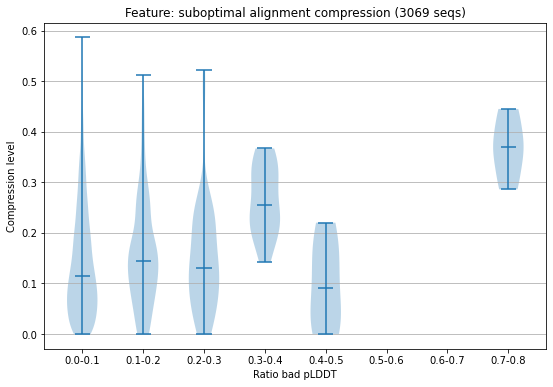

In [43]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(9, 6))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')][prop].values for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    nans = [float('nan'), float('nan')]
    ax.violinplot(dataset=[bucket if bucket.any() else nans for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

ax1.set_title('Feature: suboptimal alignment compression (3069 seqs)')
violin_plot(ax1, 'suboptim_compress', 'Compression level')

plt.show()

In [44]:
df_with_compression = df.dropna(subset=['suboptim_compress'])

In [56]:
worst_entries = df_with_compression.nsmallest(n=300, columns=['ratio_bad_plddt', 'median_plddt'])
best_entries = df_with_compression.nlargest(n=300, columns=['ratio_bad_plddt', 'median_plddt'])

In [57]:
worst_clusters = worst_entries['cluster_id'].value_counts()
best_clusters = best_entries['cluster_id'].value_counts()

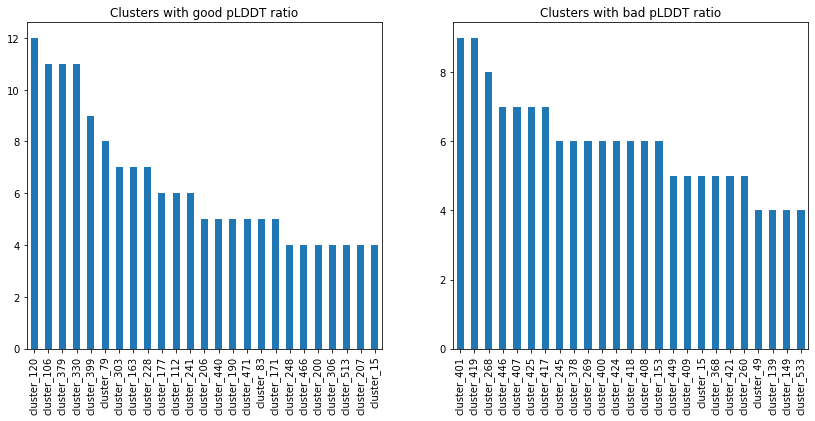

In [68]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

best_clusters[:25].plot(kind="bar", ax=ax1)
worst_clusters[:25].plot(kind="bar", ax=ax2)

ax1.set_title('Clusters with good pLDDT ratio')
ax2.set_title('Clusters with bad pLDDT ratio')

plt.show()